In [67]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


# 1. Read the file and convert from png to gray
image = cv2.imread('./resources/puzzle_2.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Split the image into its RGB channels
b, g, r = cv2.split(image)

# Thresholding on R, G, and B channels
r_thresh = cv2.threshold(r, 120, 255, cv2.THRESH_BINARY)[1]
g_thresh = cv2.threshold(g, 120, 255, cv2.THRESH_BINARY)[1]
b_thresh = cv2.threshold(b, 120, 255, cv2.THRESH_BINARY)[1]

# Combine thresholded channels
gray = cv2.bitwise_or(r_thresh, cv2.bitwise_or(g_thresh, b_thresh))

# Increase contrast and exposure using histogram equalization
gray = cv2.equalizeHist(gray)

# 2. Apply Gaussian blur
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# 3. Canny edge detection
edges = cv2.Canny(blurred, 50, 150)

# Perform Hough Line Transform
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 10, minLineLength=100, maxLineGap=10)

# Draw detected lines on a blank canvas
line_image = np.zeros_like(image)

for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 250), 20)

# Combine the original image with the detected lines
image = cv2.addWeighted(image, 0.8, line_image, 1, 0)


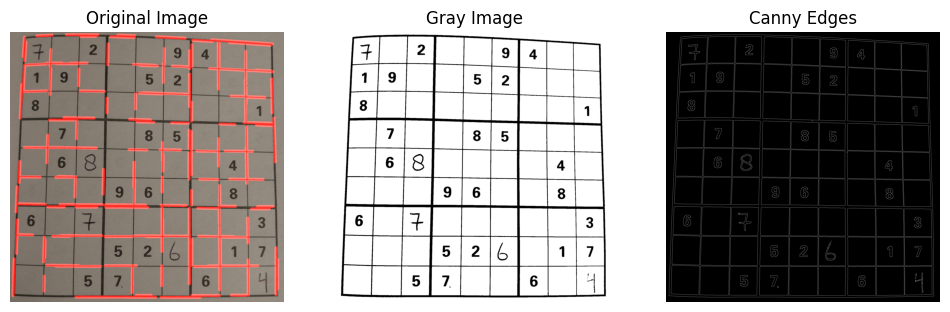

In [68]:
# Display the original image and the edges produced by Canny edge detection
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB))
plt.title('Gray Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edges')
plt.axis('off')

# plt.subplot(1, 4, 4)
# plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
# plt.title('Warped Image')
# plt.axis('off')

plt.show()